# GRU-1

## Hyperparameter tuning

- 1D convolutional layer + batch normalization + maxPooling : 4

- Hidden dimension : 128

- Number of channels : 128

- Loss function : Negative Log Likelihood

- Training epochs : 10

- Batch size : 100

- Learning rate : 0.5

- Optimizer : SGD without weight decay





In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys

import numpy as np

import math

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

from torchaudio.datasets import SPEECHCOMMANDS
import os

In [ ]:
#Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Split of the dataset and data preparation
The class SubsetSC splits the Speech Commands Dataset into train, validation and test sets. The classification of the audio files in each set is specified in the 'validation.txt' and 'testing.txt' files where are written the paths of them.

In [ ]:
class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]

In [ ]:
# Create training, validation and testing split of the data
train_set = SubsetSC("training")
val_set = SubsetSC("validation")
test_set = SubsetSC("testing")

#Tuple made of waveform, sample rate, label (spoken word), speaker ID and number of the utterance.
waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

  0%|          | 0.00/2.26G [00:00<?, ?B/s]

In [ ]:
#List of labels in the dataset (commands said by speakers)
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))

In [ ]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]

# Batched tensors for the model
To transform an array of data point made of audio and labels into two batched tensors for the model. The function collate_fn is used by the PyTorch DataLoader that allows us to iterate over a dataset by batches.

In [ ]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 100

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

# GRU-1 Model

In [ ]:
class GRU_1(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=3, hidden_dim=128, n_channel=128, nhead=2, num_layer=2):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.GRU = nn.GRU(2 * n_channel, hidden_dim, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = x.permute(0, 2, 1)
        x, hnn = self.GRU(x)
        x = self.fc1(hnn[-1])
        return F.log_softmax(x, dim=-1)

model = GRU_1(n_input=waveform.shape[0], n_output=len(labels))
model.cuda()

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

n = count_parameters(model)
#print("Number of parameters: %s" % n)

# Training and testing
In this case we use SGD optimizer without weight decay and Negative Log Likelihood as loss function.

In [ ]:
lr = 0.5

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=0.0)

In [ ]:
def train(epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.cuda()
        target = target.cuda()

        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # record loss
        losses.append(loss.item())


In [ ]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


@torch.no_grad()
def evaluate(data_source):
    model.eval()
    total_loss = 0.
    correct = 0
    n = 0
    for data, target in data_source:

        data = data.to(device)
        target = target.to(device)

        output = model(data)

        total_loss += target.numel() * F.nll_loss(output.squeeze(), target).item()
        n += target.numel()

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)
    
 
    accuracy = 100 * correct / len(test_loader.dataset)
    
    return total_loss / n, accuracy

Train Epoch: 1 [0/84843 (0%)]	Loss: 3.574499
Train Epoch: 1 [10000/84843 (12%)]	Loss: 3.154475
Train Epoch: 1 [20000/84843 (24%)]	Loss: 2.439272
Train Epoch: 1 [30000/84843 (35%)]	Loss: 1.909292
Train Epoch: 1 [40000/84843 (47%)]	Loss: 1.226803
Train Epoch: 1 [50000/84843 (59%)]	Loss: 1.123751
Train Epoch: 1 [60000/84843 (71%)]	Loss: 1.358105
Train Epoch: 1 [70000/84843 (82%)]	Loss: 0.999579
Train Epoch: 1 [80000/84843 (94%)]	Loss: 1.017075
| Validation | val loss  0.93 | val accuracy 66%
Train Epoch: 2 [0/84843 (0%)]	Loss: 0.907668
Train Epoch: 2 [10000/84843 (12%)]	Loss: 1.009373
Train Epoch: 2 [20000/84843 (24%)]	Loss: 0.604774
Train Epoch: 2 [30000/84843 (35%)]	Loss: 0.660182
Train Epoch: 2 [40000/84843 (47%)]	Loss: 0.537295
Train Epoch: 2 [50000/84843 (59%)]	Loss: 0.489522
Train Epoch: 2 [60000/84843 (71%)]	Loss: 0.462718
Train Epoch: 2 [70000/84843 (82%)]	Loss: 0.466535
Train Epoch: 2 [80000/84843 (94%)]	Loss: 0.374295
| Validation | val loss  0.54 | val accuracy 76%
Train Epoch:

Text(0.5, 1.0, 'training loss')

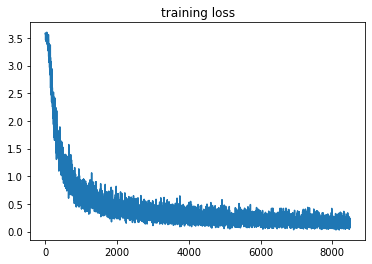

In [ ]:
best_val_loss = float("inf")
losses = []

log_interval = 100
n_epoch = 10

for epoch in range(1, n_epoch + 1):
    train(epoch, log_interval)
    val_loss, val_acc = evaluate(val_loader)

    print(f'| Validation | val loss {val_loss:5.2f} | val accuracy {val_acc:.0f}%')

    if val_loss < best_val_loss:
      with open("GRU-1_16kHz.pth", 'wb') as f:
        torch.save(model, f)
      best_val_loss = val_loss

with open("GRU-1_16kHz.pth", 'rb') as f:
  model = torch.load(f)

with torch.no_grad():
  test_loss, test_acc = evaluate(test_loader)

print('=' * 89)
print(f'| End of training | test loss {test_loss:5.2f} | test accuracy {test_acc:.0f}%')
print('=' * 89)

# Let's plot the training loss versus the number of iteration.
plt.plot(losses)
plt.title("training loss")